In [1]:
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [2]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGenerator.InputDist.RAW

num_decomps=1
num_subsets=2
num_mixtures=3

# Number of input mixtures for dense generator
num_input_mixtures = 2

balanced=True

### Learning

In [3]:
# Additive smoothing during learning
additive_smoothing=0
min_additive_smoothing=0
smoothing_decay=0.2
initial_accum_value = 20  # 20 was used for corridor

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(0, 1)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Add random values before max
add_random=None

use_unweighted=True

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/czikus/Data/mnist")

Extracting /home/czikus/Data/mnist/train-images-idx3-ubyte.gz
Extracting /home/czikus/Data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/czikus/Data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/czikus/Data/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
def show_mnist(img):
    img=np.reshape(img, (14,14))
    plt.imshow(img, interpolation='none')
    plt.show()

### Process data

In [6]:
def process_set(data):
    threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 0.5, interp='nearest').ravel() > threshold).astype(dtype=int))
    images=np.vstack(resized)
    return images

In [7]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

0


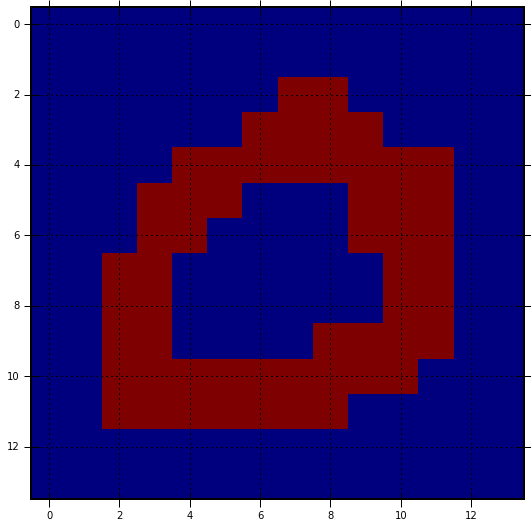

In [8]:
print(train_labels[19])
show_mnist(train_images[19])

# Generate SPN structure

In [9]:
ivs = spn.IVs(num_vars=196, num_vals=2)
dense_gen = spn.DenseSPNGenerator(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                  input_dist=input_dist, 
                                  balanced=balanced,
                                  num_input_mixtures=num_input_mixtures)
class_roots = [dense_gen.generate(ivs) for _ in range(10)]
root = spn.Sum(*class_roots)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

24014


# Add Learning Ops

In [10]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          additive_smoothing=additive_smoothing_var, add_random=add_random,
                          initial_accum_value=initial_accum_value, use_unweighted=use_unweighted)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

# Run Training

In [11]:
sess=None

In [12]:
train_set = train_images
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()
sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=1
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0
while abs(prev_likelihood - likelihood)>0.05:
    prev_likelihood=likelihood
    likelihoods = []
    for batch in range(num_batches):
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
        print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
        print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _, = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={ivs: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
        print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
        # Update weights
        sess.run(update_spn)
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
    # sess.run(reset_accumulators)

EPOCH 0 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -143.589
Avg likelihood: -143.588897705
EPOCH 1 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -50.8618
Avg likelihood: -50.8618125916
EPOCH 2 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -49.3361
Avg likelihood: -49.3361053467
EPOCH 3 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -48.7314
Avg likelihood: -48.7314109802
EPOCH 4 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -48.3912
Avg likelihood: -48.3911743164
EPOCH 5 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -48.1815
Avg likelihood: -48.1814727783
EPOCH 6 BATCH 0 SAMPLES 0 55000
Smoothing:  0.0
Avg likelihood (this batch data on previous weights): -48.041
Avg likelihood: -48.0410423279
EPOCH 7

# Generate Testing Ops

In [13]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [14]:
mpe_ivs, mpe_latent = mpe_state_gen.get_state(root, ivs, latent)

# Run Testing

### MPE of the whole network

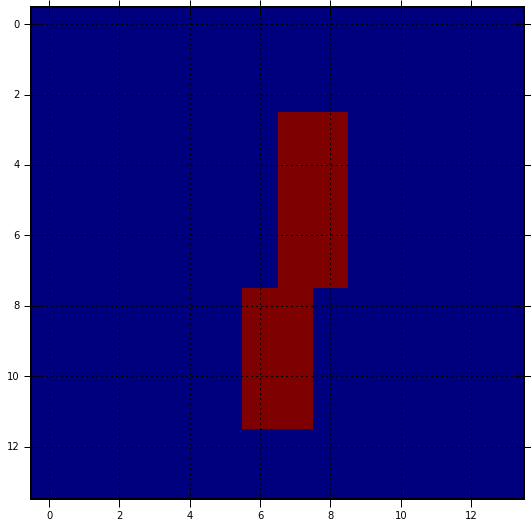

[[1]]


In [15]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[-1]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 0

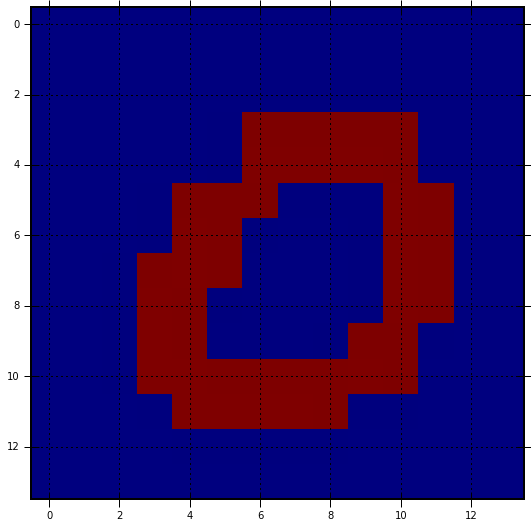

[[0]]


In [16]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[0]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 1

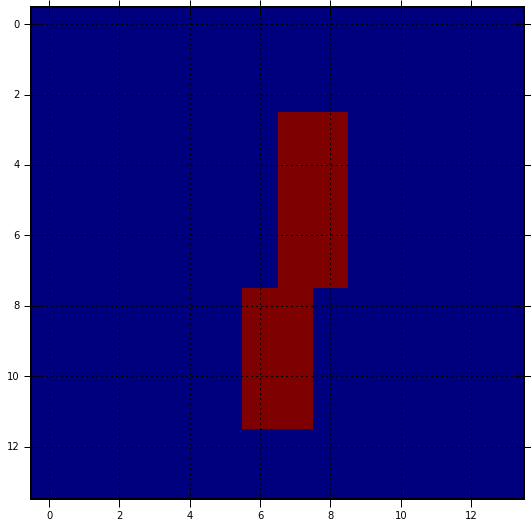

[[1]]


In [17]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[1]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 3

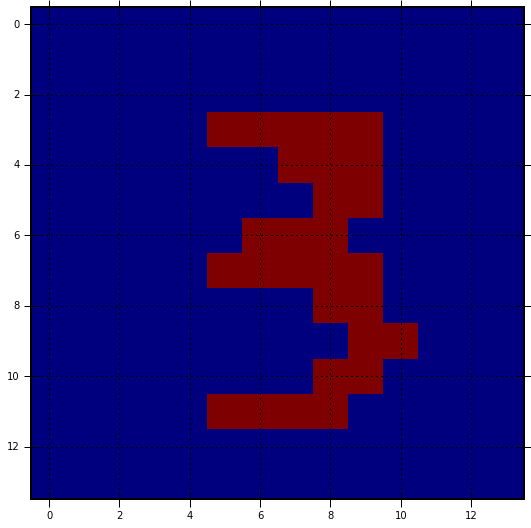

[[3]]


In [18]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[3]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### Classification of Training Data

In [19]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: train_set, 
                                                   latent: np.ones((train_set.shape[0], 1))*-1})
result=(mpe_latent_val==train_labels)
np.sum(result) / train_labels.size

0.84569090909090905

### Classification of Test Data

In [20]:
test_set = test_images
test_labels=np.reshape(test_labels, (-1, 1))

In [21]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: test_set, 
                                                   latent: np.ones((test_set.shape[0], 1))*-1})
result=(mpe_latent_val==test_labels)
np.sum(result) / test_labels.size

0.85519999999999996

# Save model

In [27]:
with sess.as_default():
    saver=spn.JSONSaver(path="/home/pronobis/mnist_all_classes.spn")
    saver.save(root)

KeyboardInterrupt: 